<a href="https://colab.research.google.com/github/Ramsha-amir26/DAP-TABA/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import sys
sys.path.append('/content/drive/MyDrive/fewshotscripts/')

import prototypical_network
import train_and_evaluation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4
from torchvision import models
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

import pandas as pd
from sklearn.metrics import classification_report

import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
class CFG:
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)


augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED)
], name='augmentation_layer')

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, clahe_image, augmented_image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(clahe_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')

    axes[2].imshow(augmented_image)
    axes[2].set_title("Image after Augmentation")
    axes[2].axis('off')

    plt.show()

def read_xray_images(directory_path, img_height, img_width, selected_classes=None, augmentation=True,
                     normalize=False, apply_clahe_flag=True, display_comparison=False):
    datax = []
    datay = []

    sub_directories = os.listdir(directory_path)

    if selected_classes is None:
        selected_classes = sub_directories
    else:
        for cls in selected_classes:
            if cls not in sub_directories:
                raise ValueError(f"Class '{cls}' not found in {directory_path}. Available classes: {sub_directories}")

    for sub_dir in selected_classes:
        sub_dir_path = os.path.join(directory_path, sub_dir)
        correct_image_filepaths = check_image_path(sub_dir_path)

        for fpath in correct_image_filepaths:
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))

            original_image = image.copy()

            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
                image = enhanced_image

            if augmentation:
                image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
                augmented_image = augmentation_layer(image_tensor)  # Apply augmentation layer
                augmented_image = augmented_image.numpy().astype(np.uint8)  # Convert back to numpy array

            if normalize:
                image = image / 255.0

            if display_comparison:
                display_image_comparison(original_image, enhanced_image, augmented_image)

            datax.append(image)
            datay.append(sub_dir)

    return np.array(datax), np.array(datay)

In [17]:
densenet121_model = models.densenet121(pretrained=True)

In [18]:
densenet121_model = densenet121_model.to(device)
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [20]:
for param in densenet121_model.parameters():
  param.requires_grad = False

In [21]:
densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

In [22]:
import zipfile
zip_file_path = r"/content/drive/MyDrive/Datasets/FewShotGroups.zip"
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group1"

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("/content/drive/MyDrive/Datasets/")
    print(f"Extracted FewShotGroups to {test_data_dir}")
else:
    print(f"{zip_file_path} not found!")

Extracted FewShotGroups to /content/drive/MyDrive/Datasets/FewShotGroups/Group1


In [23]:
def generate_classification_report(results, sample_images):
    y_true_flat = results["y_true"].flatten()
    y_pred_flat = results["y_pred"].flatten()


    class_labels = sample_images["class_labels"]
    label_mapping = {i: label for i, label in enumerate(class_labels)}


    report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
    return report

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(results):
    """
    Generates and plots the Receiver Operating Characteristic (ROC) curve.
    """

    y_true_flat = results["y_true"].flatten()
    y_scores = results["y_pred"].flatten()

    fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [25]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)

    cmap = plt.cm.Blues
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)


    disp.plot(cmap=cmap, values_format='d')


    plt.title("Confusion Matrix", fontsize=12, pad=20)
    plt.grid(False)
    plt.colorbar(disp.im_, fraction=0.046, pad=0.04)


    plt.tight_layout()
    plt.show()

In [26]:
def test_model_on_one_task(model, n_way, n_support, n_query, test_episodes, x_test, y_test, output_dir, file_name):
    """
    Tests the Prototypical Network on a test set and saves every 100th episode result to a CSV file.

    Args:
        model: trained model
        n_way (int): number of classes in a classification task
        n_support (int): number of images per class in the support set
        n_query (int): number of images per class in the query set
        test_episodes (int): number of episodes to test on
        x_test (np.array): images of testing set
        y_test (np.array): labels of testing set
        output_dir (str): Directory to save the CSV file
        file_name (str): The name of the CSV file to save results

    Returns:
        avg_loss (float): average loss
        avg_acc (float): average accuracy
    """

    running_loss = 0.0
    running_acc = 0.0


    results = []
    model.eval()

    print(f"Saving loss and accuracy every 100 episodes: ")
    with torch.no_grad():
        for episode in range(test_episodes):
            sample = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']


            if episode % 100 == 0:
                print(f"Episode: {episode} ---> Loss: {output['loss']:.3f}, Accuracy: {output['acc']:.2f}")

                results.append({
                    'Episode': episode,
                    'Loss': output['loss'],
                    'Accuracy': output['acc']
                })

        avg_loss = running_loss / test_episodes
        avg_acc = running_acc / test_episodes


    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    csv_path = os.path.join(output_dir, file_name)
    df = pd.DataFrame(results)
    df.to_csv(csv_path, index=False)

    return avg_loss, avg_acc

## **GROUP 1**

In [27]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group1"
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

In [28]:
x_test.shape, y_test.shape

((60, 224, 224, 3), (60,))

Class labels sampled: ['Covid19' 'Effusion']


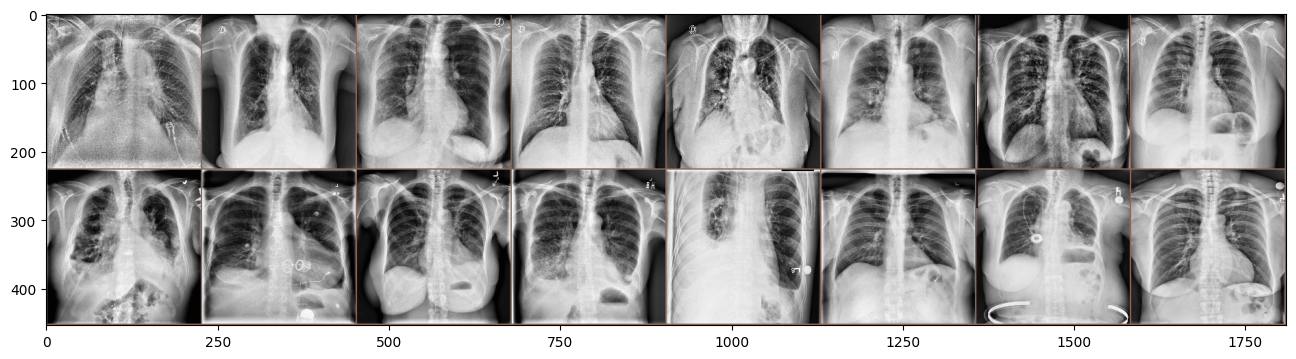

In [29]:
n_way = 2
n_support = 5
n_query = 3
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

In [30]:
import csv
output_dir = '/content/drive/MyDrive/Colab_Results/DENSENET121'

os.makedirs(output_dir, exist_ok=True)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 1

In [31]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'densenet121_2_way_3shot_testing_group1.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 15.051, Accuracy: 0.75
Episode: 100 ---> Loss: 3.277, Accuracy: 0.80
Episode: 200 ---> Loss: 0.418, Accuracy: 0.90
Episode: 300 ---> Loss: 7.652, Accuracy: 0.75
Episode: 400 ---> Loss: 6.986, Accuracy: 0.70
Episode: 500 ---> Loss: 18.681, Accuracy: 0.80
Episode: 600 ---> Loss: 8.383, Accuracy: 0.75
Episode: 700 ---> Loss: 18.025, Accuracy: 0.55
Episode: 800 ---> Loss: 4.599, Accuracy: 0.75
Episode: 900 ---> Loss: 4.952, Accuracy: 0.80
Episode: 1000 ---> Loss: 10.512, Accuracy: 0.70
Episode: 1100 ---> Loss: 16.622, Accuracy: 0.70
Episode: 1200 ---> Loss: 9.239, Accuracy: 0.80
Episode: 1300 ---> Loss: 13.105, Accuracy: 0.70
Episode: 1400 ---> Loss: 5.032, Accuracy: 0.85
Episode: 1500 ---> Loss: 2.732, Accuracy: 0.85
Episode: 1600 ---> Loss: 7.922, Accuracy: 0.85
Episode: 1700 ---> Loss: 4.991, Accuracy: 0.85
Episode: 1800 ---> Loss: 7.884, Accuracy: 0.60
Episode: 1900 ---> Loss: 6.448, Accuracy: 0.65
Episode: 2000 ---> L

### Prototypical Network Prediction with densenet121 2 Way 3 Shot

Class labels sampled: ['Covid19' 'Effusion']
{'loss': 10.168392181396484, 'acc': 0.75, 'y_hat': tensor([[1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1]])}


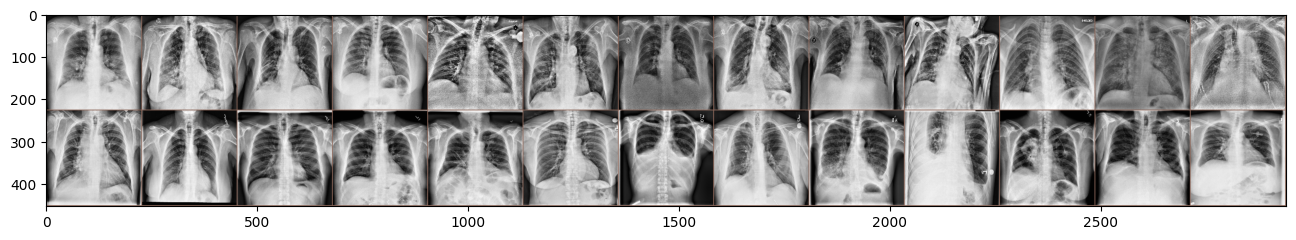

In [32]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [33]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2_way_3shot_results_group1.csv"), index=False)
print("Results saved to prototypical_model_results_densenet121_2way_3shot_group1.csv")

Results saved to prototypical_model_results_densenet121_2way_3shot_group1.csv


### Classification Report

In [34]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

     Covid19       0.86      0.60      0.71        10
    Effusion       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



### ROC Curve

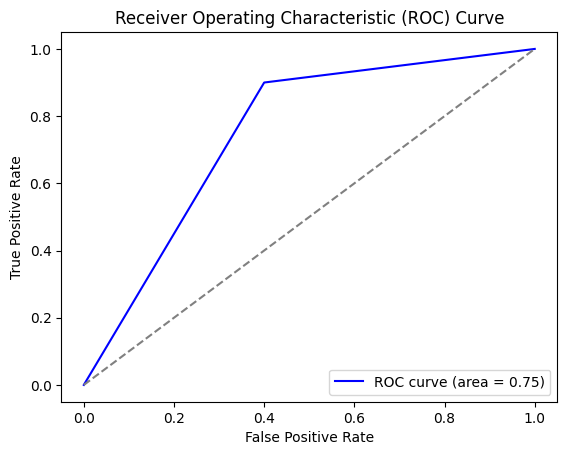

In [35]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

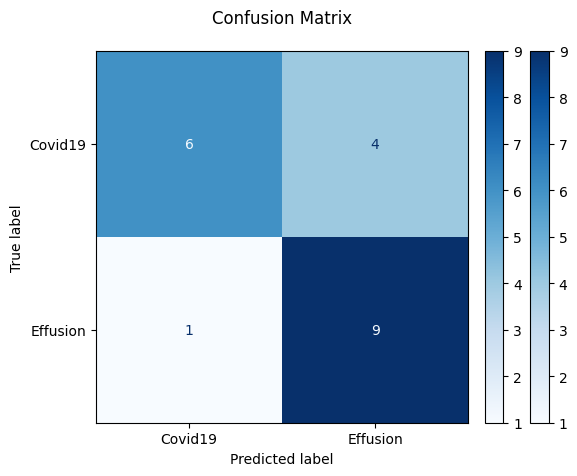

In [36]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 1

In [37]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'densenet121_2_way_5shot_testing_group1.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 4.195, Accuracy: 0.87
Episode: 100 ---> Loss: 13.897, Accuracy: 0.73
Episode: 200 ---> Loss: 11.708, Accuracy: 0.63
Episode: 300 ---> Loss: 4.412, Accuracy: 0.83
Episode: 400 ---> Loss: 5.330, Accuracy: 0.77
Episode: 500 ---> Loss: 7.416, Accuracy: 0.80
Episode: 600 ---> Loss: 2.082, Accuracy: 0.83
Episode: 700 ---> Loss: 7.389, Accuracy: 0.73
Episode: 800 ---> Loss: 8.633, Accuracy: 0.80
Episode: 900 ---> Loss: 1.497, Accuracy: 0.93
Episode: 1000 ---> Loss: 4.165, Accuracy: 0.77
Episode: 1100 ---> Loss: 3.604, Accuracy: 0.80
Episode: 1200 ---> Loss: 11.350, Accuracy: 0.67
Episode: 1300 ---> Loss: 2.402, Accuracy: 0.80
Episode: 1400 ---> Loss: 1.383, Accuracy: 0.87
Episode: 1500 ---> Loss: 6.088, Accuracy: 0.87
Episode: 1600 ---> Loss: 3.101, Accuracy: 0.80
Episode: 1700 ---> Loss: 2.956, Accuracy: 0.83
Episode: 1800 ---> Loss: 7.913, Accuracy: 0.63
Episode: 1900 ---> Loss: 2.428, Accuracy: 0.80
Episode: 2000 ---> Loss

### Prototypical Network Prediction with densenet121 2 Way 5 Shot Group 1

Class labels sampled: ['Effusion' 'Covid19']
{'loss': 12.373144149780273, 'acc': 0.7333333492279053, 'y_hat': tensor([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])}


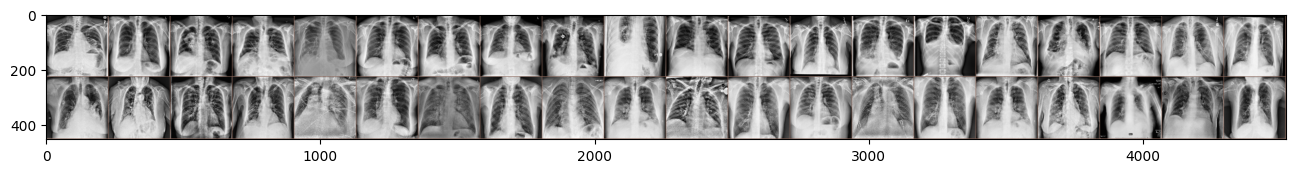

In [38]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [39]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2way_5shot_results_group1.csv"), index=False)
print("Results saved to densenet121_2way_5shot_group1.csv")

Results saved to densenet121_2way_5shot_group1.csv


### Classification Report

In [40]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

    Effusion       0.71      0.80      0.75        15
     Covid19       0.77      0.67      0.71        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



### ROC curve

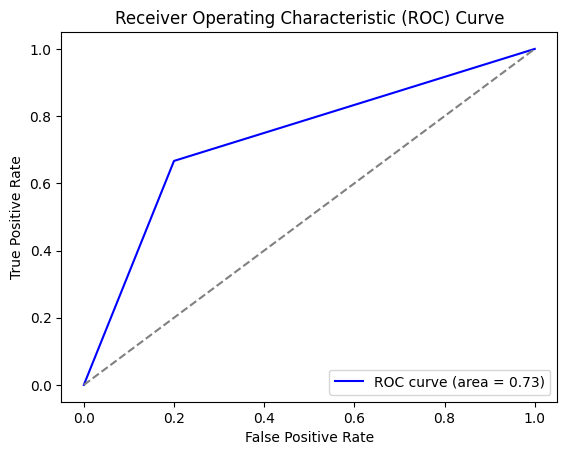

In [41]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

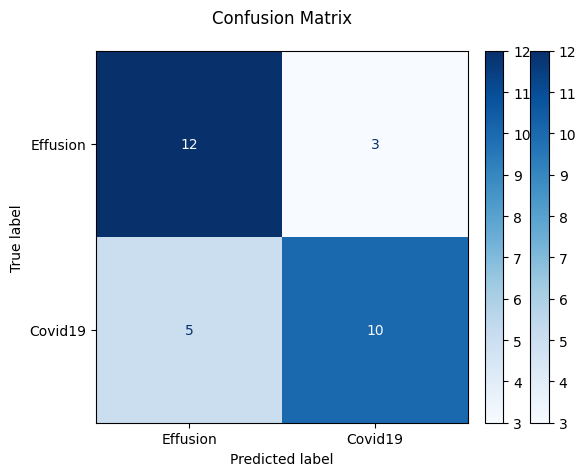

In [42]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

## **GROUP 2**

In [43]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group2"
data_dir = test_data_dir
selected_classes = ['Pneumonia', 'Cardiomegaly']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 2

In [44]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'densenet121_2_way_3shot_testing_group2.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 23.046, Accuracy: 0.55
Episode: 100 ---> Loss: 15.620, Accuracy: 0.60
Episode: 200 ---> Loss: 31.245, Accuracy: 0.50
Episode: 300 ---> Loss: 19.527, Accuracy: 0.55
Episode: 400 ---> Loss: 23.940, Accuracy: 0.50
Episode: 500 ---> Loss: 17.931, Accuracy: 0.55
Episode: 600 ---> Loss: 23.350, Accuracy: 0.40
Episode: 700 ---> Loss: 23.385, Accuracy: 0.60
Episode: 800 ---> Loss: 19.876, Accuracy: 0.65
Episode: 900 ---> Loss: 32.669, Accuracy: 0.60
Episode: 1000 ---> Loss: 8.968, Accuracy: 0.65
Episode: 1100 ---> Loss: 20.453, Accuracy: 0.60
Episode: 1200 ---> Loss: 61.274, Accuracy: 0.60
Episode: 1300 ---> Loss: 8.459, Accuracy: 0.60
Episode: 1400 ---> Loss: 16.203, Accuracy: 0.40
Episode: 1500 ---> Loss: 7.578, Accuracy: 0.50
Episode: 1600 ---> Loss: 41.210, Accuracy: 0.35
Episode: 1700 ---> Loss: 19.750, Accuracy: 0.60
Episode: 1800 ---> Loss: 18.058, Accuracy: 0.45
Episode: 1900 ---> Loss: 46.213, Accuracy: 0.55
Episode: 

### Prototypical Network Prediction with densenet121 2 Way 3 Shot Group 2

Class labels sampled: ['Cardiomegaly' 'Pneumonia']
{'loss': 24.20841407775879, 'acc': 0.550000011920929, 'y_hat': tensor([[1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0, 1, 1]])}


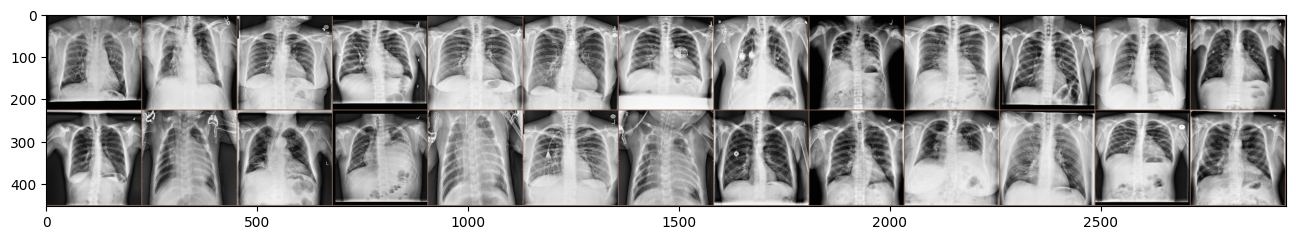

In [45]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [46]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2_way_3shot_results_group2.csv"), index=False)
print("Results saved to prototypical_model_results_densenet121_2way_3shot_group2.csv")

Results saved to prototypical_model_results_densenet121_2way_3shot_group2.csv


### Classification Report

In [47]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

Cardiomegaly       0.56      0.50      0.53        10
   Pneumonia       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



### ROC Curve

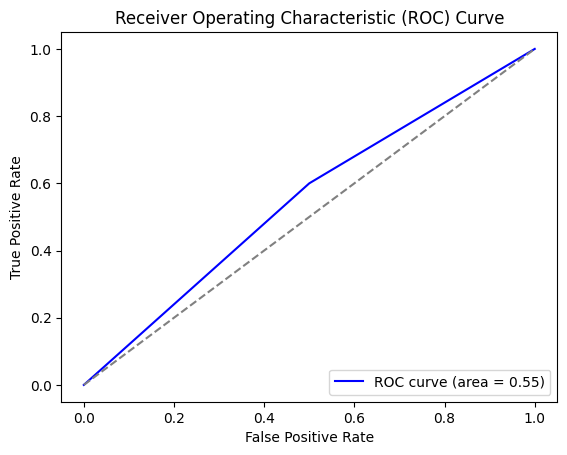

In [48]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

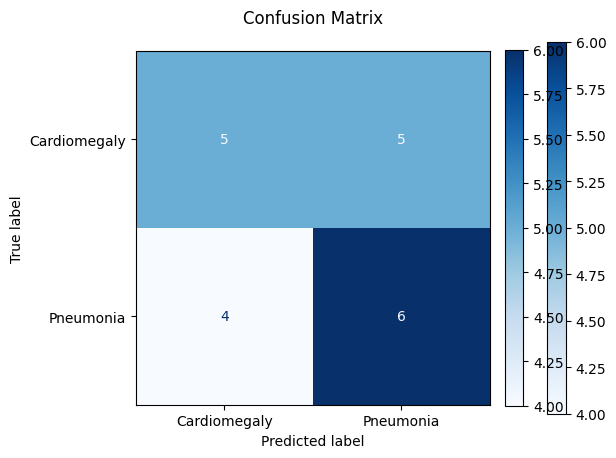

In [49]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 2

In [50]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'densenet121_2_way_5shot_testing_group2.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 10.491, Accuracy: 0.57
Episode: 100 ---> Loss: 16.181, Accuracy: 0.50
Episode: 200 ---> Loss: 12.531, Accuracy: 0.57
Episode: 300 ---> Loss: 19.529, Accuracy: 0.50
Episode: 400 ---> Loss: 12.353, Accuracy: 0.57
Episode: 500 ---> Loss: 9.827, Accuracy: 0.57
Episode: 600 ---> Loss: 21.684, Accuracy: 0.30
Episode: 700 ---> Loss: 7.005, Accuracy: 0.63
Episode: 800 ---> Loss: 19.382, Accuracy: 0.63
Episode: 900 ---> Loss: 12.832, Accuracy: 0.57
Episode: 1000 ---> Loss: 7.752, Accuracy: 0.50
Episode: 1100 ---> Loss: 10.483, Accuracy: 0.67
Episode: 1200 ---> Loss: 8.333, Accuracy: 0.60
Episode: 1300 ---> Loss: 15.106, Accuracy: 0.57
Episode: 1400 ---> Loss: 10.596, Accuracy: 0.67
Episode: 1500 ---> Loss: 20.491, Accuracy: 0.60
Episode: 1600 ---> Loss: 18.442, Accuracy: 0.63
Episode: 1700 ---> Loss: 17.940, Accuracy: 0.43
Episode: 1800 ---> Loss: 11.256, Accuracy: 0.60
Episode: 1900 ---> Loss: 9.751, Accuracy: 0.53
Episode: 20

### Prototypical Network Prediction with densenet121 2 Way 5 Shot Group 2

Class labels sampled: ['Pneumonia' 'Cardiomegaly']
{'loss': 18.369070053100586, 'acc': 0.4333333671092987, 'y_hat': tensor([[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]])}


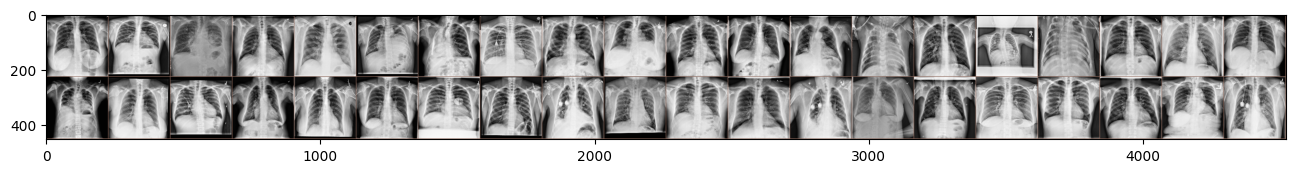

In [51]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [52]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2_way_5shot_results_group2.csv"), index=False)
print("Results saved to densenet121_2_way_5shot_results_group2.csv")

Results saved to densenet121_2_way_5shot_results_group2.csv


### Classification Report

In [53]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

   Pneumonia       0.45      0.67      0.54        15
Cardiomegaly       0.38      0.20      0.26        15

    accuracy                           0.43        30
   macro avg       0.41      0.43      0.40        30
weighted avg       0.41      0.43      0.40        30



### ROC Curve

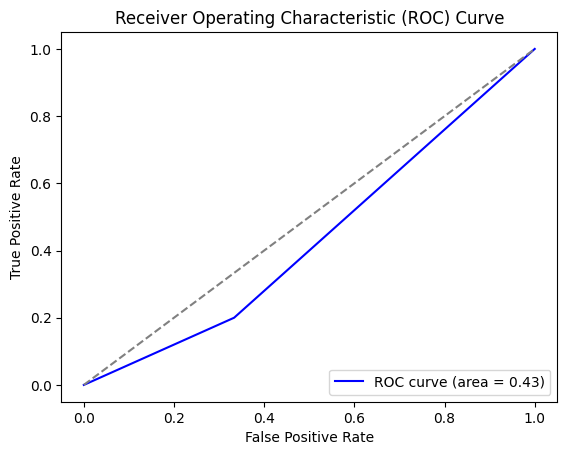

In [54]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

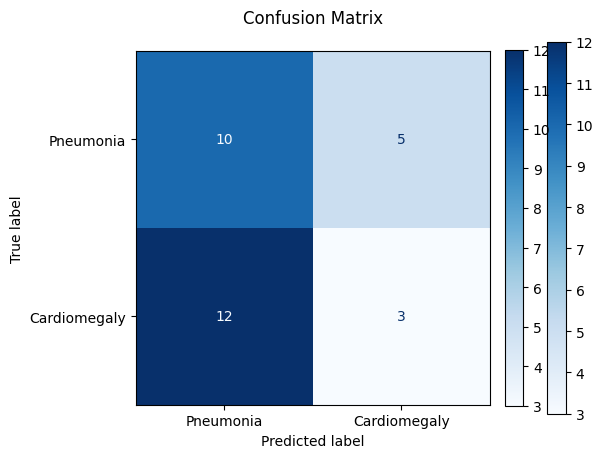

In [55]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

## **GROUP 3**

In [56]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group3"
data_dir = test_data_dir
selected_classes = ['Atelectasis', 'Fibrosis']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 3

In [57]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'densenet121_2_way_3shot_testing_group3.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 18.225, Accuracy: 0.60
Episode: 100 ---> Loss: 10.576, Accuracy: 0.40
Episode: 200 ---> Loss: 18.843, Accuracy: 0.40
Episode: 300 ---> Loss: 23.766, Accuracy: 0.40
Episode: 400 ---> Loss: 31.855, Accuracy: 0.40
Episode: 500 ---> Loss: 36.497, Accuracy: 0.40
Episode: 600 ---> Loss: 41.352, Accuracy: 0.45
Episode: 700 ---> Loss: 18.168, Accuracy: 0.40
Episode: 800 ---> Loss: 25.526, Accuracy: 0.30
Episode: 900 ---> Loss: 16.903, Accuracy: 0.55
Episode: 1000 ---> Loss: 6.525, Accuracy: 0.55
Episode: 1100 ---> Loss: 16.315, Accuracy: 0.40
Episode: 1200 ---> Loss: 13.007, Accuracy: 0.55
Episode: 1300 ---> Loss: 13.106, Accuracy: 0.45
Episode: 1400 ---> Loss: 16.609, Accuracy: 0.55
Episode: 1500 ---> Loss: 14.894, Accuracy: 0.60
Episode: 1600 ---> Loss: 13.633, Accuracy: 0.55
Episode: 1700 ---> Loss: 29.271, Accuracy: 0.30
Episode: 1800 ---> Loss: 32.127, Accuracy: 0.35
Episode: 1900 ---> Loss: 14.637, Accuracy: 0.40
Episode

### Prototypical Network Prediction with densenet121 2 Way 5 Shot Group 3

Class labels sampled: ['Atelectasis' 'Fibrosis']
{'loss': 18.62506675720215, 'acc': 0.4000000059604645, 'y_hat': tensor([[0, 1, 0, 0, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0]])}


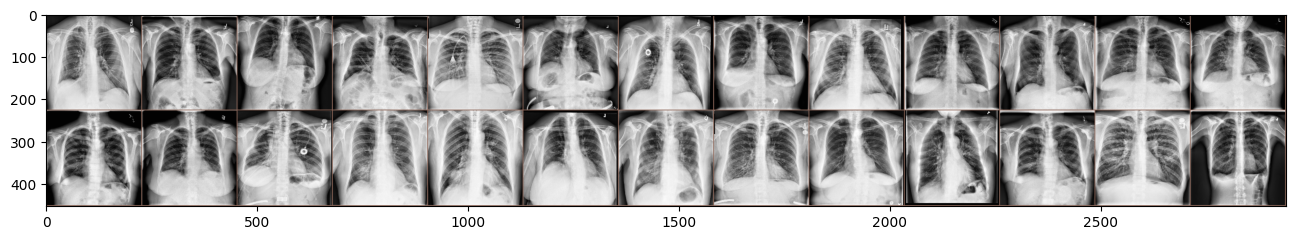

In [58]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [59]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2_way_3shot_results_group3.csv"), index=False)
print("Results saved to densenet121_2_way_3shot_results_group3.csv")

Results saved to densenet121_2_way_3shot_results_group3.csv


### Classification Report

In [60]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

 Atelectasis       0.40      0.40      0.40        10
    Fibrosis       0.40      0.40      0.40        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.40        20
weighted avg       0.40      0.40      0.40        20



### ROC Curve

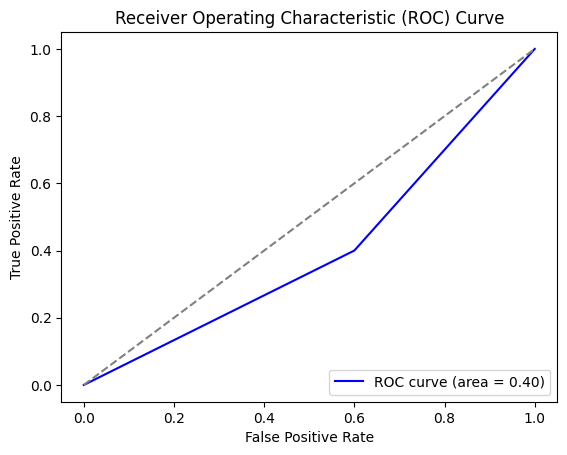

In [61]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

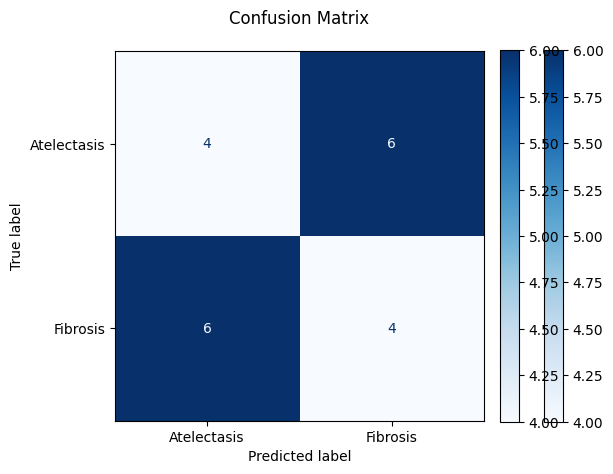

In [62]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 2

In [63]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'densenet121_2_way_5shot_testing_group3.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 11.766, Accuracy: 0.57
Episode: 100 ---> Loss: 9.748, Accuracy: 0.53
Episode: 200 ---> Loss: 10.937, Accuracy: 0.60
Episode: 300 ---> Loss: 12.881, Accuracy: 0.47
Episode: 400 ---> Loss: 12.405, Accuracy: 0.43
Episode: 500 ---> Loss: 8.977, Accuracy: 0.63
Episode: 600 ---> Loss: 6.761, Accuracy: 0.47
Episode: 700 ---> Loss: 27.318, Accuracy: 0.37
Episode: 800 ---> Loss: 16.164, Accuracy: 0.33
Episode: 900 ---> Loss: 8.705, Accuracy: 0.60
Episode: 1000 ---> Loss: 10.715, Accuracy: 0.53
Episode: 1100 ---> Loss: 10.484, Accuracy: 0.53
Episode: 1200 ---> Loss: 11.664, Accuracy: 0.53
Episode: 1300 ---> Loss: 14.647, Accuracy: 0.43
Episode: 1400 ---> Loss: 9.557, Accuracy: 0.47
Episode: 1500 ---> Loss: 8.666, Accuracy: 0.53
Episode: 1600 ---> Loss: 4.107, Accuracy: 0.60
Episode: 1700 ---> Loss: 11.071, Accuracy: 0.57
Episode: 1800 ---> Loss: 11.084, Accuracy: 0.57
Episode: 1900 ---> Loss: 5.779, Accuracy: 0.53
Episode: 2000 

### Prototypical Network Prediction with densenet121 2 Way 5 Shot Group 3

Class labels sampled: ['Fibrosis' 'Atelectasis']
{'loss': 11.702133178710938, 'acc': 0.46666669845581055, 'y_hat': tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]])}


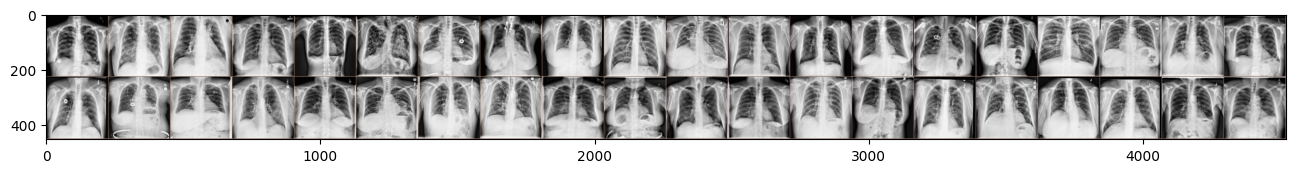

In [64]:
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [65]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "densenet121_2_way_5shot_results_group3.csv"), index=False)
print("Results saved to densenet12150_2_way_5shot_results_group3.csv")

Results saved to densenet12150_2_way_5shot_results_group3.csv


### Classification Report

In [66]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

    Fibrosis       0.44      0.27      0.33        15
 Atelectasis       0.48      0.67      0.56        15

    accuracy                           0.47        30
   macro avg       0.46      0.47      0.44        30
weighted avg       0.46      0.47      0.44        30



### ROC Curve

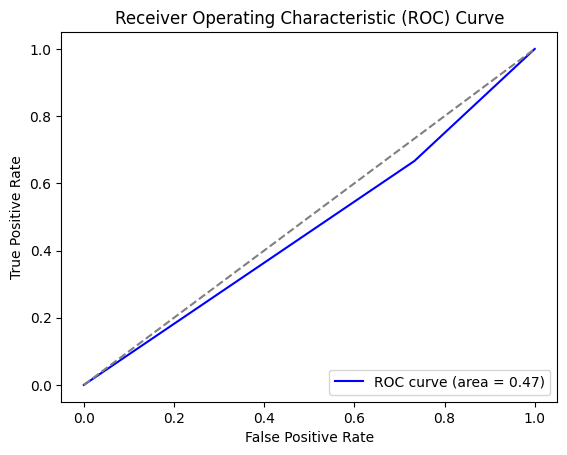

In [67]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

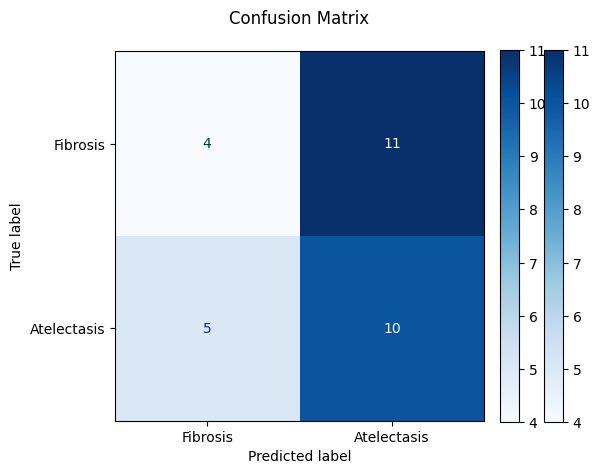

In [68]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)